In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

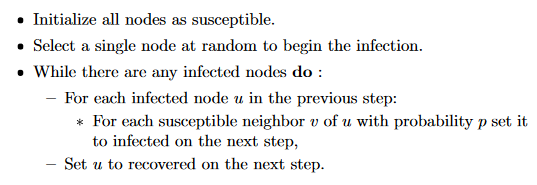

In [19]:
def sir_netw(G, p, origin = None):
    """
#    Single run of the SIR model on network.
    """
    
    N = len(G)
    infected = []
    
    # initialize nodes
    for node in G.nodes():
        G.nodes[node]["state"] = "S" # all healthy at the beginning

    #inject the 'zero' patient randomly
    if origin == None:
        node = random.randint(0, N - 1)
        G.nodes[node]["state"] = "I"
        infected = [node]
    else:
        G.nodes[origin]["state"] = "I"
        infected = [origin]
    
    results = [[N - 1, 1, 0, nx.G.copy().nodes]]
    
    #time loop
    while results[-1][1] != 0:
        new_infected = []
        ns = results[-1][0]
        ni = results[-1][1]
        nr = results[-1][2]
        
        for node in infected:
            for neigh in G.neighbors(node):
                if G.nodes[neigh]["state"] == "S":
                    q = random.random()
                    if q < p:
                        G.nodes[neigh]["state"] = "I"
                        new_infected.append(neigh)
                        ns -= 1
                        ni += 1
            G.nodes[node]["state"] = "R"
            ni -= 1
            nr += 1
        results.append([ns, ni, nr, G.nodes])
        infected = new_infected
    return results

In [44]:
G.copy()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [46]:
numb_nodes = 20
G = nx.erdos_renyi_graph(numb_nodes, 0.5)

In [47]:
for node in G.nodes():
    G.nodes[node]["state"] = "S"

In [48]:
res = []
res.append(G.copy().nodes)

In [49]:
for node in res[0]:
    print(G.nodes[node]["state"])

S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S


In [50]:
G.nodes[0]["state"] = "I"

In [51]:
for node in G:
    print(G.nodes[node]["state"])

I
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S


In [52]:
for node in res[0]:
    print(G.nodes[node]["state"])

I
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S
S


In [20]:
p = 0.5
res = sir_netw(G, p)

In [23]:
res

[[19,
  1,
  0,
  NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))],
 [15,
  4,
  1,
  NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))],
 [3,
  12,
  5,
  NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))],
 [0,
  3,
  17,
  NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))],
 [0,
  0,
  20,
  NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))]]

In [33]:
for j in range(4):
    print(j)
    for i in res[j][-1]:
        print(G1[i])

0
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
1
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
2
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
3
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'state': 'R'}
{'

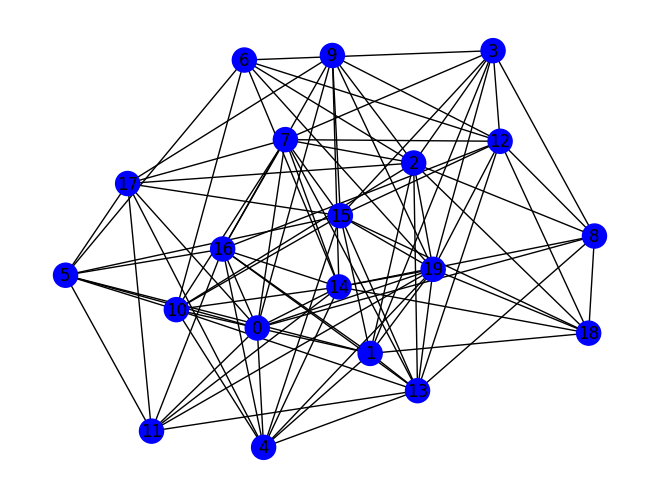

In [25]:

color_map = []
G1 = res[0][-1]
for node in G1:
    if G1[node]["state"] == "S":
        color_map.append('green')
    elif G1[node]["state"] == "I":
        color_map.append('red')
    else:
        color_map.append('blue')

nx.draw(G, with_labels = True, node_color = color_map)
# ['red' if node == v[i] else 'blue' for node in G]    
# nx.draw_kamada_kawai(G, with_labels = True, node_color = color_map)
# plt.savefig(f'grw(1)_{i}.png')
# frames.append(Image.open(f'grw(1)_{i}.png'))
# plt.close()

In [ ]:
#simulation parameters
# TRIALS = 1000
# MCS = 100    #number of Monte Carlo steps
NODES = 50  #number of nodes
p = 0.5  #transmission probability
# gamma = 0.1 #recovery rate


averages = [[0, 0, 0]]

#build the contact network
G = nx.barabasi_albert_graph(NODES, 4)

# start MC experiment
for trial in range(TRIALS):
    res = sir_netw(G, p)
    averages = averages + res
    
averages = averages/TRIALS    

In [ ]:
plt.plot(list(range(MCS)),averages[:,0],label="S")
plt.plot(list(range(MCS)),averages[:,1],label="I")
plt.plot(list(range(MCS)),averages[:,2],label="R")
plt.legend()
plt.xlabel("Time (MCS)")
plt.ylabel("Population size")

In [7]:
numb_nodes = 20
G = nx.erdos_renyi_graph(numb_nodes, 0.5)

In [14]:
nodes = G.nodes

In [15]:
nodes[2]

{'state': 'S'}

In [11]:
for node in G.nodes():
    G.nodes[node]["state"] = "S"

In [27]:
G.add_nodes_from('abcde')

In [ ]:
for node, data in G.nodes(data = True):
    print(f"node: {node}")
    print(f"data: {data}")
    print(f"data['state']: {data['state']}")

In [35]:
results = [[10 - 1, 1, 0], [1, 2, 3], [1, 4, 5]]

In [36]:
results

[[9, 1, 0], [1, 2, 3], [1, 4, 5]]

In [37]:
results[-1][1]

4

In [45]:
random.random()

0.12024890040837333

In [2]:
random.seed()

def sir(G,steps,beta,gamma):
    """Single run of the SIR model on network."""
    
    results = np.zeros((steps,3), dtype=float)
    GSIZE = len(G)
    
    #initialize nodes
    for nd in G.nodes():
        G.nodes[nd]["state"] = "S" #all healthy at the beginning

    #inject the 'zero' patient randomly
    nd = random.randint(0,GSIZE-1)
    G.nodes[nd]["state"] = "I"

    #time loop
    for step in range(steps):
        counter = 0
        # single time step begins here
        while counter < GSIZE: #event loop
            counter = counter + 1
            #pick a node randomly
            nd = random.choice(list(G.nodes))
            if G.nodes[nd]['state'] == 'I': #if infected
                if random.random() < gamma: #recovery?  (prob. gamma)
                    G.nodes[nd]['state'] = 'R'
                else: #infect a healthy neighbor (with prob. beta)
                    neigh = random.choice(list(G.neighbors(nd)))
                    if G.nodes[neigh]['state'] == 'S' and random.random()<beta: 
                        G.nodes[neigh]['state'] = 'I'

        #find the numbers of agents in each class after each time step                
        sl, il, rl = 0, 0, 0
        for node, data in G.nodes(data=True):
            if data['state'] == 'S':
                sl += 1
            elif data['state'] == 'I':
                il += 1
            else:
                rl += 1
            
        results[step] = sl, il, rl
    return results

In [3]:
#simulation parameters
TRIALS = 10
MCS = 5  #number of Monte Carlo steps
NODES = 50  #number of nodes
beta = 1.0  #transmission probability
gamma = 0.1 #recovery rate


averages = np.zeros((MCS,3), dtype=float)
print(f"averages = {averages}")

#build the contact network
G = nx.barabasi_albert_graph(NODES,4)

# start MC experiment
for trial in range(TRIALS):
    res = sir(G,MCS,beta,gamma)
    print(f"res = {res}")
    averages = averages + res
    print(f"averages = {averages}")
    
averages = averages/TRIALS    
print(f"averages = {averages}")

averages = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
res = [[48.  2.  0.]
 [47.  2.  1.]
 [47.  2.  1.]
 [47.  1.  2.]
 [47.  1.  2.]]
averages = [[48.  2.  0.]
 [47.  2.  1.]
 [47.  2.  1.]
 [47.  1.  2.]
 [47.  1.  2.]]
res = [[49.  1.  0.]
 [49.  1.  0.]
 [46.  4.  0.]
 [44.  5.  1.]
 [42.  7.  1.]]
averages = [[97.  3.  0.]
 [96.  3.  1.]
 [93.  6.  1.]
 [91.  6.  3.]
 [89.  8.  3.]]
res = [[48.  2.  0.]
 [48.  2.  0.]
 [48.  2.  0.]
 [45.  5.  0.]
 [43.  7.  0.]]
averages = [[145.   5.   0.]
 [144.   5.   1.]
 [141.   8.   1.]
 [136.  11.   3.]
 [132.  15.   3.]]
res = [[46.  3.  1.]
 [42.  7.  1.]
 [40.  8.  2.]
 [37. 11.  2.]
 [35. 12.  3.]]
averages = [[191.   8.   1.]
 [186.  12.   2.]
 [181.  16.   3.]
 [173.  22.   5.]
 [167.  27.   6.]]
res = [[47.  2.  1.]
 [47.  1.  2.]
 [47.  1.  2.]
 [44.  4.  2.]
 [41.  7.  2.]]
averages = [[238.  10.   2.]
 [233.  13.   4.]
 [228.  17.   5.]
 [217.  26.   7.]
 [208.  34.   8.]]
res = [[49.  1.  0.]
 [49.  1.  0.]
 [

Text(0, 0.5, 'Population size')

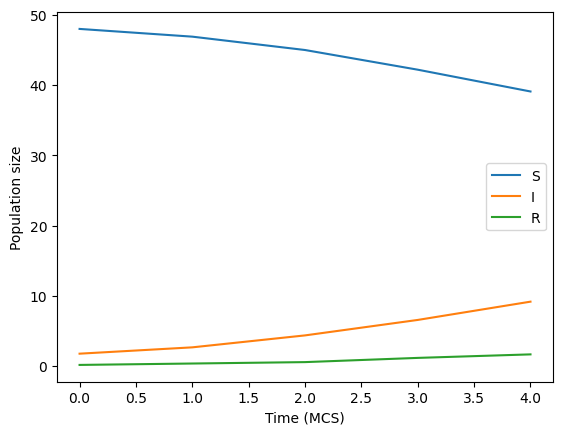

In [4]:
plt.plot(list(range(MCS)),averages[:,0],label="S")
plt.plot(list(range(MCS)),averages[:,1],label="I")
plt.plot(list(range(MCS)),averages[:,2],label="R")
plt.legend()
plt.xlabel("Time (MCS)")
plt.ylabel("Population size")